In [1]:
from PI_class_EnbPI import prediction_interval
import utils_EnbPI as util
from matplotlib.lines import Line2D  # For legend handles
import statsmodels as sm
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
import itertools
import time
import pandas as pd
import numpy as np
import os
import sys
import keras
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'PI_class_EnbPI'

In [ ]:
# Read data and initialize parameters
max_data_size = 10000
dataSolar_Atl = util.read_data(3, 'Data/Solar_Atl_data.csv', max_data_size)
stride = 1
miss_test_idx = []
alpha = 0.1
tot_trial = 10  # For CP methods that randomizes
np.random.seed(98765)
B = 30  # number of bootstrap samples
Data_name = ['Solar_Atl']
response_ls = {'Solar_Atl': 'DHI'}
min_alpha = 0.0001
max_alpha = 10
ridge_cv = RidgeCV(alphas=np.linspace(min_alpha, max_alpha, 10))
random_forest = RandomForestRegressor(n_estimators=10, criterion='mse',
                                      bootstrap=False, max_depth=2, n_jobs=-1)

(8760, 8)


## Marginal Coverage, change $\alpha$

In [ ]:
alpha_ls = np.linspace(0.05, 0.25, 5)
tot_trial = 10  # For CP
methods = ['Ensemble']
rnn = True
energy_data = False  # True for Palo Alto only, as it is a network

data = eval(f'data{data_name}')  # Pandas DataFrame
data_x = data.loc[:, data.columns != response_ls[data_name]]
data_y = data[response_ls[data_name]]
data_x_numpy = data_x.to_numpy()  # Convert to numpy
data_y_numpy = data_y.to_numpy()  # Convert to numpy
total_data_points = data_x_numpy.shape[0]
train_size = int(0.2 * total_data_points)
results = pd.DataFrame(columns=['itrial', 'dataname', 'muh_fun',
                                'method', 'alpha', 'coverage', 'width'])
results_ts = pd.DataFrame(columns=['itrial', 'dataname',
                                   'method', 'alpha', 'coverage', 'width'])
for itrial in range(tot_trial):
np.random.seed(98765 + itrial)
for alpha in alpha_ls:
nnet = util.keras_mod()  # Note, this is necessary because a model may "remember the past"
rnnet = util.keras_rnn()
print(f'At trial # {itrial} and alpha={alpha}')
print(f'For {data_name}')
if energy_data:
    X_train, X_predict, Y_train, Y_predict = big_transform(
        Data_name, data_name, one_dim, train_size)
    d = 20
else:
    X_train = data_x_numpy[:train_size, :]
    X_predict = data_x_numpy[train_size:, :]
    Y_train = data_y_numpy[:train_size]
    Y_predict = data_y_numpy[train_size:]
    d = 20  # for 1-d memory depth
    if one_dim:
        X_train, X_predict, Y_train, Y_predict = one_dimen_transform(
            Y_train, Y_predict, d=d)
ridge_results = prediction_interval(
    ridge_cv,  X_train, X_predict, Y_train, Y_predict)
rf_results = prediction_interval(
    random_forest,  X_train, X_predict, Y_train, Y_predict)
nn_results = prediction_interval(
    nnet,  X_train, X_predict, Y_train, Y_predict)
if rnn:
    T, k = X_train.shape
    T1 = X_predict.shape[0]
    X_train = X_train.reshape((T, 1, k))
    X_predict = X_predict.reshape((T1, 1, k))
    rnn_results = prediction_interval(
        rnnet, X_train, X_predict, Y_train, Y_predict)
if itrial == 0:
    # For ARIMA, only run once
    result_ts = ridge_results.run_experiments(
        alpha, B, stride, data_name, itrial, miss_test_idx, methods=methods, none_CP=True)
    result_ts.rename(columns={'train_size': 'alpha'}, inplace=True)
    if one_dim:
        result_ts['alpha'].replace(
            train_size - d, alpha, inplace=True)
    else:
        result_ts['alpha'].replace(train_size, alpha, inplace=True)
    results_ts = pd.concat([results_ts, result_ts])
    results_ts.to_csv(f'Results/{data_name}_many_alpha_new_ARIMA.csv', index=False)
# CP Methods
print(f'regressor is {ridge_cv.__class__.__name__}')
result_ridge = ridge_results.run_experiments(
    alpha, B, stride, data_name, itrial, miss_test_idx, methods=methods)
print(f'regressor is {random_forest.__class__.__name__}')
result_rf = rf_results.run_experiments(
    alpha, B, stride, data_name, itrial, miss_test_idx, methods=methods)
print(f'regressor is {nnet.name}')
# start = time.time()
result_nn = nn_results.run_experiments(
    alpha, B, stride, data_name, itrial, miss_test_idx, methods=methods)
if rnn:
    print(f'regressor is {rnnet.name}')
    result_rnn = rnn_results.run_experiments(
        alpha, B, stride, data_name, itrial, miss_test_idx, methods=methods)
    result_rnn['muh_fun'] = 'RNN'
    results_now = pd.concat([result_ridge, result_rf, result_nn, result_rnn])
else:
    results_now = pd.concat([result_ridge, result_rf, result_nn])
results_now.rename(columns={'train_size': 'alpha'}, inplace=True)
if one_dim:
    results_now['alpha'].replace(
        train_size - d, alpha, inplace=True)
else:
    results_now['alpha'].replace(train_size, alpha, inplace=True)
results = pd.concat([results, results_now])
if one_dim:
    results.to_csv(f'Results/{data_name}_many_alpha_new_1d.csv', index=False)
else:
    results.to_csv(f'Results/{data_name}_many_alpha_new.csv', index=False)



data1 = pd.read_csv(f'Results/{data_name}_many_alpha_new{which}.csv')
data1.reset_index(inplace=True)
print(data1.shape)
data1.to_csv(f'Results/{data_name}_many_alpha_new{which}.csv', index=False)


data_name
merge_arima(data_name, '_1d')
merge_arima(data_name, '')

### Plotting

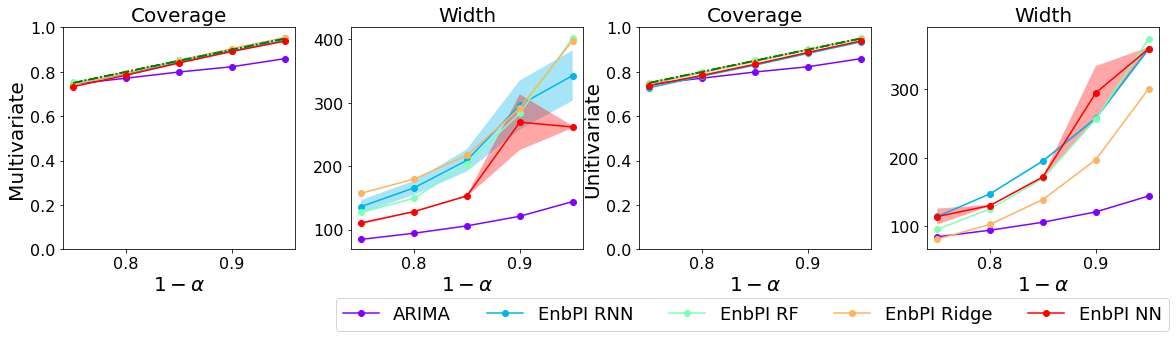

In [ ]:
alpha_ls = np.linspace(0.05, 0.25, 5)
x_axis = 1-alpha_ls
x_axis_name = 'alpha'
two_rows = False
util.plot_average_new(x_axis, x_axis_name, two_rows=two_rows)